**ST446 Distributed Computing for Big Data**, LT 2021

---


# Seminar 9: scaling up machine learning


## Exercise 1: Scaling up machine learning by compressing gradient updates

In the lecture, we discussed how distributed training of machine learning models, using the data parallel computation model, can be scaled up by compressing gradient updates sent by work nodes to the parameter server. For large machine learning models, this can significantly reduce the time required to communicate gradient vector updates in each iteration of the stochastic gradient algorithm, and result in an overall computation time speed up. This is of particular interest when learning high-dimensional models, like deep neural networks with hundreds of millions of parameters. 

In this exercise, our goal is to evaluate the effect of compressing gradient vector updates on the training loss for a simple logistic regression model in Spark. To this end, we would like to extend the code developed in one of our previous exercises, namely,

https://github.com/lse-st446/lectures2021/blob/master/Week08/class/logistic_regression_batch_gradient_descent.ipynb 

with using quantized gradient updates. 

In [ ]:
# change to where Spark lives on your machine/compute engine ($SPARK_HOME)
spark_home = "file:///usr/lib/spark"

Loading in data

In [ ]:
import sys
import numpy as np
from numpy.linalg import norm
import os
import matplotlib.pyplot as plt
%matplotlib inline

# input
D = 16             # Number of dimensions
mini_batch = 32    # Number of workers/mini_batch_size
iterations = 150   # Number of iterations
num_repeat = 5     # Number of repeated experiments

def readPointBatch(iterator):
    strs = list(iterator)
    matrix = np.zeros((len(strs), D + 1))
    for i, s in enumerate(strs):
        matrix[i] = np.fromstring(s, dtype=np.float32, sep=' ')
    return [matrix]

def add(x, y):
    x += y
    return x

points = spark.read.text(spark_home+"/data/mllib/sample_svm_data.txt").rdd.repartition(mini_batch)
# here we will be using the partitions as batches.

n = points.count() # Number of data points

points = points.map(lambda r: r[0])\
    .mapPartitions(readPointBatch).cache() 

`mapPartition` operates on individual partitions of the RDD, that is, our own `for` loop inside `readPointBatch` will iterate though the elements of each partition.
Here, caching the data prevents future re-loading of the data upon each lazy evaluation. This is important, as we will later use it in each iteration of the gradient descent.

### Quantized stochastic gradient descent

We use the MapReduce distributed computation model to implement the QSGD model over a cluster of machines.

* Before computing: the dataset is divided into `mini_batch` parts and distributedly stored on the worker nodes.

* Map step (local computation on workers): calculating the quantized stochastic gradient using the local stored dataset.

* Reduce step (synchronous operation on the server): averaging all the quantized stochastic gradients transmitted from all workers.

In [ ]:
class LogisticRegressionWithQSGD:
    def __init__(self, quantize_func, D):
        self.quantize = quantize_func
        self.weights = 2 * np.random.ranf(size=D) - 1
        self.errs = []
        self.nonzeros = [] # Number of non-zero weights
    
    # Compute logistic regression gradient for a matrix of data points
    def gradient(self, matrix):
        # randomly pick an observation
        idx = np.random.randint(matrix.shape[0])
        Y = matrix[idx, 0]    # point labels (first column of input file)
        X = matrix[idx, 1:]   # point coordinates
        return -(X.T * (Y - 1.0/(1.0+np.exp(-X.dot(self.weights)))))
    
    def pred_err(self, matrix):
        Y = matrix[:, 0]
        X = matrix[:, 1:]
        err = sum(Y!=(1.0/(1.0+np.exp(-X.dot(self.weights)))>0.5))  # this is the number of miss-classified examples.
        return (err)
    
    def train(self, labeled_data, max_iter, step_size):
        # number of workers
        num_batch = labeled_data.getNumPartitions()
        for i in range(max_iter):
            # compute the quantized gradient within each worker
           g = labeled_data.map(self.gradient) \
                           .map(self.quantize)            
            # transmit, decode and average the quantized gradients from workers                                       
            delta_w = g.reduce(decode_add) / num_batch                                             
            # gradient descent step
            self.weights -= step_size * delta_w                               
            # compute the prediction error
            self.errs.append(labeled_data.map(lambda m: self.pred_err(m)).reduce(add))  
            # compute the number of nonzero weights transmitted
            num_nonzero = g.map(lambda grad: norm(grad, 0)).sum()
            self.nonzeros.append(num_nonzero)

def decode_add(x, y):
    x+=y
    return x

def model_vs_iter(quantize_func):
    err_rate = np.zeros(iterations)
    nonzeros = np.zeros(iterations)
    for j in range(num_repeat):
        np.random.seed(j*10) # generate a new seed for every repetition
        model = LogisticRegressionWithQSGD(quantize_func, D)
        model.train(points, iterations, 0.2)
        err_rate += [ mistakes / float(n) /num_repeat  for mistakes in model.errs]
        nonzeros += [ nonzero / num_repeat  for nonzero in model.nonzeros]
    return err_rate, nonzeros

### Simple quantized gradient method

We implement the simple quantized gradient method described in **slide 34** of the [lecture notes](https://github.com/lse-st446/lectures2021/blob/master/Week10/lse-st446-lecture9.pdf) in the `simple_quantize()` below.

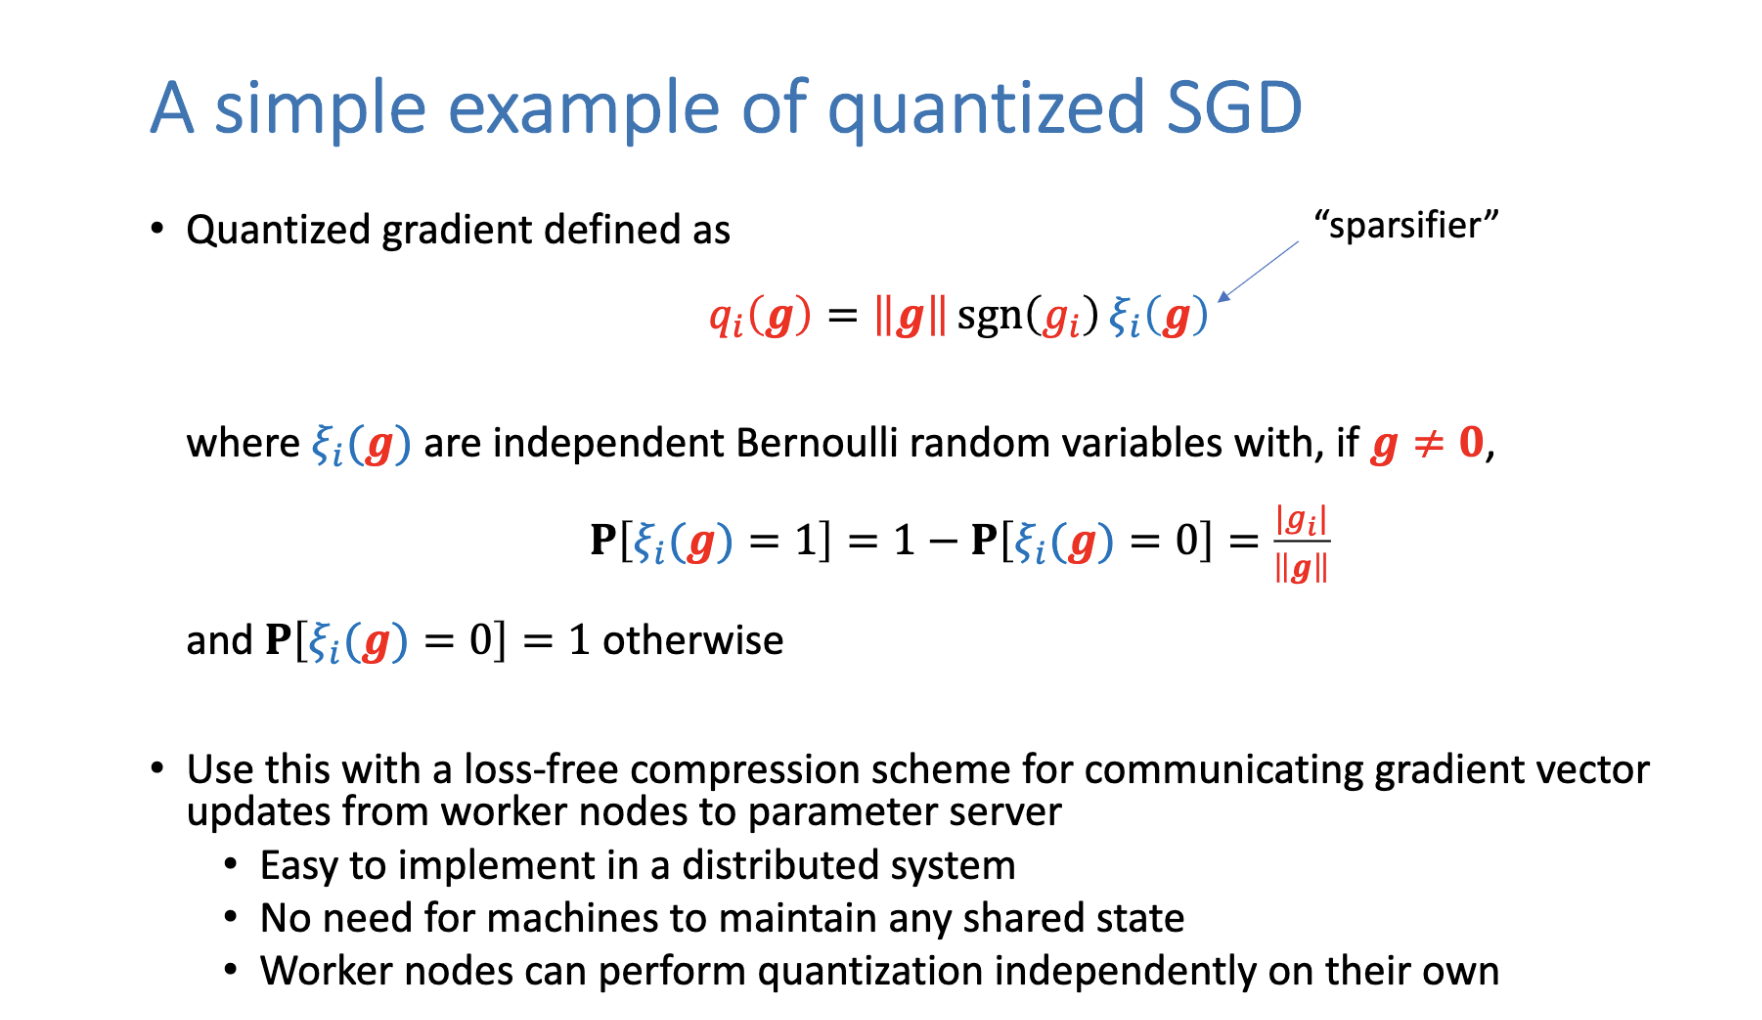

In [ ]:
from IPython.display import Image
Image(filename='./simple_qsdg.png')

In [ ]:
def simple_quantize(gradient):
    p = abs(gradient) / norm(gradient)
    xi = np.random.binomial(1, p)
    return norm(gradient) * np.sign(gradient) * xi

In [ ]:
# no quantization
lr_sgd_err, lr_sgd_nonzeros = model_vs_iter(lambda x: x)
# simple quantization
lr_sqsgd_err, lr_sqsgd_nonzeros  = model_vs_iter(simple_quantize)

#### Training error:

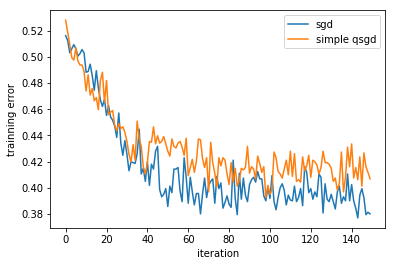

In [ ]:
plt.plot(lr_sgd_err, label='sgd')
plt.plot(lr_sqsgd_err, label='simple qsgd')
plt.xlabel("iteration")
plt.ylabel("trainning error")
plt.xticks(np.arange(0, iterations+1, 20))
plt.legend()
plt.show()

#### Communication cost

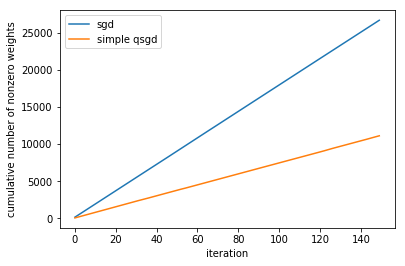

In [ ]:
plt.plot(np.cumsum(lr_sgd_nonzeros), label='sgd')
plt.plot(np.cumsum(lr_sqsgd_nonzeros), label='simple qsgd')
plt.xlabel("iteration")
plt.ylabel("cumulative number of nonzero weights")
plt.xticks(np.arange(0, iterations+1, 20))
plt.legend()
plt.show()

### Controllable quantized gradient method

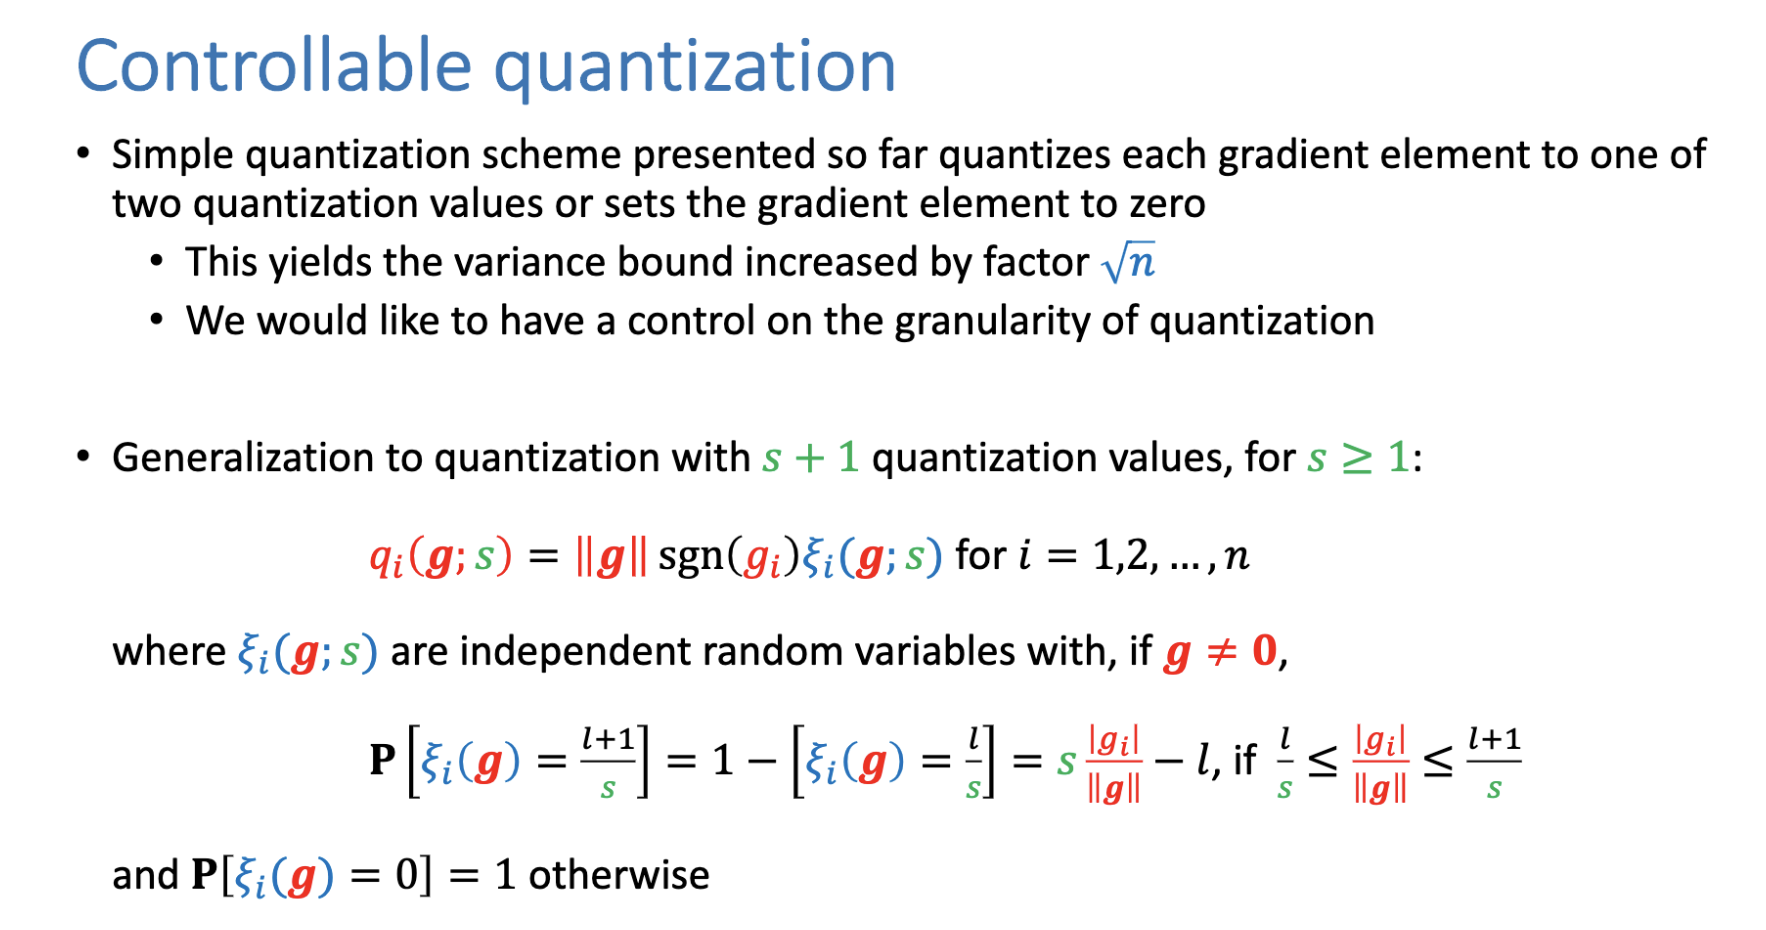

In [ ]:
from IPython.display import Image
Image(filename='./control_qsdg.png')

In [ ]:
def control_quantize(gradient, s):
    t = s * abs(gradient) / norm(gradient)
    l = np.ceil(t-1)
    xi = (l + np.random.binomial(1, t - l))  / s
    return norm(gradient) * np.sign(gradient) * xi

In [ ]:
# controllable quantization
s_list = [1, 2, 3, 4]
lr_cqsgd_err = []
lr_cqsgd_nonzeros = []
for s in s_list:
    err, nonzeros = model_vs_iter(lambda g: control_quantize(g, s))
    lr_cqsgd_err.append(err)
    lr_cqsgd_nonzeros.append(nonzeros)

#### Training error

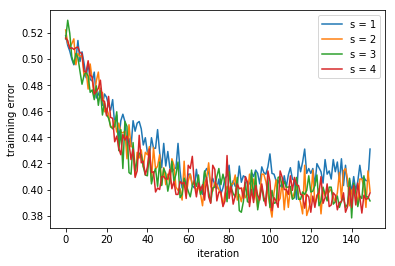

In [ ]:
for idx, curve in enumerate(lr_cqsgd_err):
    plt.plot(curve, label='s = %s' %s_list[idx] )   
plt.xlabel("iteration")
plt.ylabel("trainning error")
plt.xticks(np.arange(0, iterations+1, 20))
plt.legend()
plt.show()

#### Communication cost

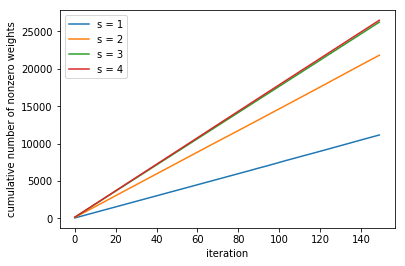

In [ ]:
for idx, curve in enumerate(lr_cqsgd_nonzeros):
    plt.plot(np.cumsum(curve), label='s = %s' %s_list[idx] )   
plt.xlabel("iteration")
plt.ylabel("cumulative number of nonzero weights")
plt.xticks(np.arange(0, iterations+1, 20))
plt.legend()
plt.show()